In [1]:
### Step 0: Setup ----

# Uncomment and adjust to install libraries not available on Google Colab
# !pip install packagename

# Load any libraries used for this project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)


In [ ]:

# Load data
#from google.colab import files  # so we can upload a CSV to our notebook

#uploaded = files.upload() # opens a file chooser to select our csv file

ice_cream = pd.read_csv("Ice Cream Sales Dataset.csv")

In [ ]:
# -------------------------------------------------------------------
# Step 1: Pre-processing
# -------------------------------------------------------------------

print("Do we have missing values? Look at 'Non-Null Count'")
print(ice_cream.info())
## until train-test split -> do not bias yourself

Do we have missing values? Look at 'Non-Null Count'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Age      50 non-null     int64
 1   buy_ind  50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


In [ ]:
# -------------------------------------------------------------------
# Step 2: Train/Test split
# -------------------------------------------------------------------

# split into training and test sets
ice_cream_train, ice_cream_test = train_test_split(
    ice_cream,
    test_size=0.3,
    random_state=385,
    stratify=ice_cream["buy_ind"]
)

## stratify argu -> get an equal proprotion in the train and test set 
## make it a fair evaluator (evenly distributed)






In [6]:
# -------------------------------------------------------------------
# Step 3: Data exploration
# -------------------------------------------------------------------


# Basic summary stats
print("\nTrain summary:")
print(ice_cream_train.describe())








Train summary:
             Age    buy_ind
count  35.000000  35.000000
mean   41.285714   0.314286
std    21.564638   0.471008
min     6.000000   0.000000
25%    24.500000   0.000000
50%    42.000000   0.000000
75%    58.000000   1.000000
max    76.000000   1.000000


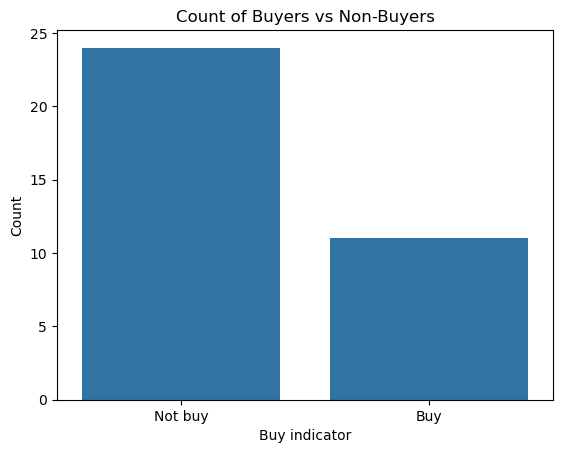

In [7]:

# Make a labeled version of buy_ind to make plotting easier
ice_cream_train["buy_label"] = ice_cream_train["buy_ind"].map({0: "Not buy", 1: "Buy"})


# Basic bar plot of buy_ind
sns.countplot(data=ice_cream_train, x="buy_label")
plt.xlabel("Buy indicator")
plt.ylabel("Count")
plt.title("Count of Buyers vs Non-Buyers")
plt.show()

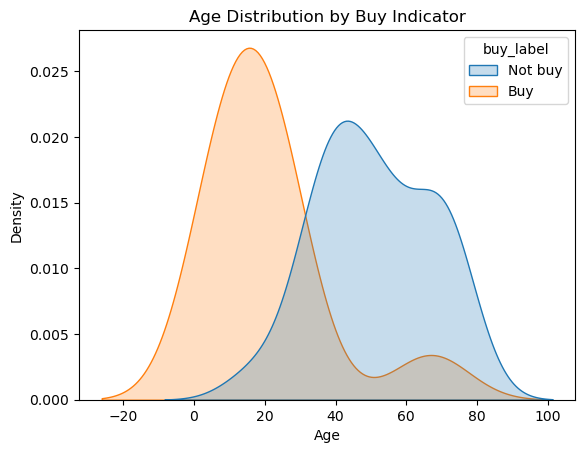

In [8]:
# Single plot with two densities: age for buy = 1 vs buy = 0
# This gives you two smooth curves on one plot: age distribution for buyers vs non-buyers.

sns.kdeplot(
    data=ice_cream_train,
    x="Age",
    hue="buy_label",
    fill=True,       # shaded areas
    common_norm=False
)
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Age Distribution by Buy Indicator")
plt.show()


In [9]:

# Marginal distribution: Age category vs Buy / Not Buy

# create an indicator of Age >= 40 or not
ice_cream_train["age_cat"] = np.where(
    ice_cream_train["Age"] >= 40,
    "Age >= 40",
    "Age < 40"
)

tab = pd.crosstab(ice_cream_train["age_cat"], ice_cream_train["buy_label"])
prop_by_row = tab.div(tab.sum(axis=1), axis=0)

print("\nMarginal distribution (row proportions):")
print(prop_by_row)


Marginal distribution (row proportions):
buy_label       Buy   Not buy
age_cat                      
Age < 40   0.588235  0.411765
Age >= 40  0.055556  0.944444


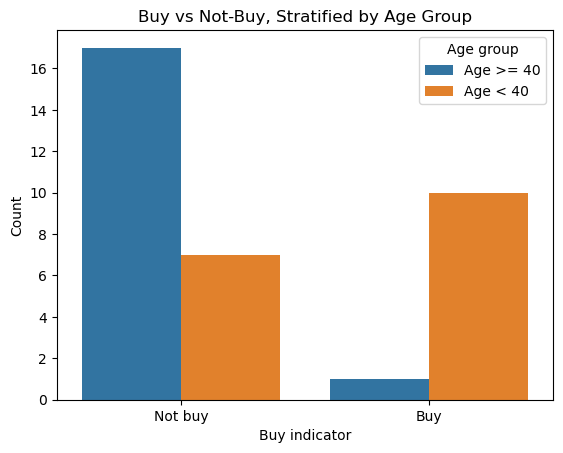

In [10]:

# Bar plot of buy_ind stratified by age >= 40


# Now a grouped bar plot: buy vs not-buy, with bars split by age group:
sns.countplot(data=ice_cream_train, x="buy_label", hue="age_cat")
plt.xlabel("Buy indicator")
plt.ylabel("Count")
plt.title("Buy vs Not-Buy, Stratified by Age Group")
plt.legend(title="Age group")
plt.show()



In [ ]:
# Step 4: Feature Engineering

# no feature engineering for this example

In [11]:
# -------------------------------------------------------------------
# Step 5: Fit simple logistic regression: buy_ind ~ Age
# -------------------------------------------------------------------

# Fit the model
logit_model = sm.Logit(
    ice_cream_train["buy_ind"], # target variable
    sm.add_constant(ice_cream_train[["Age"]]) # predictor variable + constant for intercept
    ).fit() # fit the model

# get summary
print("\nLogistic regression (buy_ind ~ Age):")
print(logit_model.summary())





Optimization terminated successfully.
         Current function value: 0.342516
         Iterations 7

Logistic regression (buy_ind ~ Age):
                           Logit Regression Results                           
Dep. Variable:                buy_ind   No. Observations:                   35
Model:                          Logit   Df Residuals:                       33
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Nov 2025   Pseudo R-squ.:                  0.4498
Time:                        20:55:14   Log-Likelihood:                -11.988
converged:                       True   LL-Null:                       -21.787
Covariance Type:            nonrobust   LLR p-value:                 9.557e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1998      1.296      2.469      0.014       0.660    

In [12]:
# Extract coefficients and compute odds ratios and odds marginal effects
coefs = logit_model.params.to_frame("estimate")
coefs["odds_estimate"] = np.exp(coefs["estimate"])
coefs["odds_mfx"] = coefs["odds_estimate"] - 1

print("\nCoefficients with odds ratios and odds-based marginal effects:")
print(coefs)


Coefficients with odds ratios and odds-based marginal effects:
       estimate  odds_estimate   odds_mfx
const  3.199832      24.528412  23.528412
Age   -0.116714       0.889840  -0.110160


In [ ]:
# For reference: Training with scikit-learn for pure prediction tasks

# Create model
model = LogisticRegression(solver="lbfgs", max_iter=1000)
## solver = lbfgs -> the algorithm -> logistic regeression 

# Fit model
model.fit(
    ice_cream_train[['Age']], # note double brackets to preserve data frame (not series)
    ice_cream_train['buy_ind']
    )

# extract coefficients
# small numerical differences may appear due to differences in training algorithm
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: [3.19438353]
Coefficients: [[-0.11653319]]


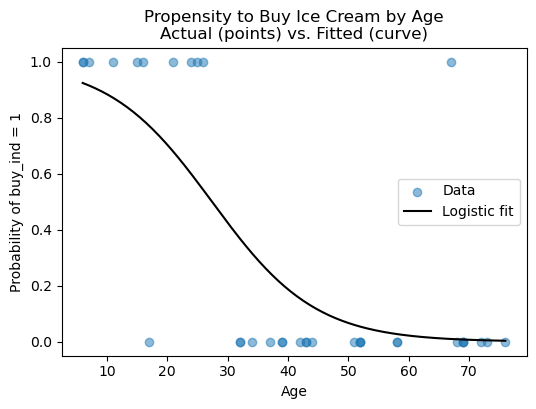

In [14]:
# -------------------------------------------------------------------
# Plot simple logistic fit
# -------------------------------------------------------------------

# Create evenly spaced values across the range of Age for a smooth curve
age_grid = np.linspace(ice_cream_train["Age"].min(), ice_cream_train["Age"].max(), 200)

pred_df = pd.DataFrame({"Age": age_grid})

# Predicted probabilities from the logistic model over evenly-spaced Age
p_hat = logit_model.predict(sm.add_constant(pred_df))


# scatter plot of actual age values
plt.figure(figsize=(6, 4))
plt.scatter(ice_cream_train["Age"], ice_cream_train["buy_ind"], alpha=0.5, label="Data")

# plot the logistic line
plt.plot(age_grid, p_hat, label="Logistic fit", color="black")

# add labels and show the plot
plt.xlabel("Age")
plt.ylabel("Probability of buy_ind = 1")
plt.title("Propensity to Buy Ice Cream by Age\nActual (points) vs. Fitted (curve)")
plt.legend()
plt.show()



Average marginal effects (logistic, overall):
        Logit Marginal Effects       
Dep. Variable:                buy_ind
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0126      0.001    -11.968      0.000      -0.015      -0.011

Average marginal effect of Age on P(buy): -0.0126


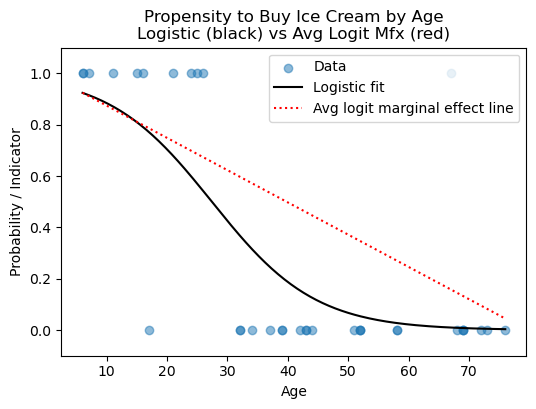

In [15]:
# -------------------------------------------------------------------
# Logistic vs Approximate Linear Marginal Effects
# -------------------------------------------------------------------


# Average marginal effect from logistic model
mfx_overall = logit_model.get_margeff(at="overall", method="dydx")

print("\nAverage marginal effects (logistic, overall):")
print(mfx_overall.summary())

avg_mfx_age = float(mfx_overall.margeff[0])
print(f"\nAverage marginal effect of Age on P(buy): {avg_mfx_age:.4f}")

# Plot logistic vs “avg marginal effect” line

# start with actual values
plt.figure(figsize=(6, 4))
plt.scatter(ice_cream_train["Age"], ice_cream_train["buy_ind"], alpha=0.5, label="Data")

# Logistic curve (black)
plt.plot(age_grid, p_hat, label="Logistic fit", color="black")


# “Avg marginal effect” line (red, dotted)
# For illustration: start at 1 when Age=0 and decrease at avg_mfx_age per year
mfx_line = 1 + avg_mfx_age * age_grid
plt.plot(age_grid, mfx_line, color="red", linestyle=":", label="Avg logit marginal effect line")

plt.xlabel("Age")
plt.ylabel("Probability / Indicator")
plt.title("Propensity to Buy Ice Cream by Age\n"
          "Logistic (black) vs Avg Logit Mfx (red)")
plt.legend()
plt.ylim(-0.1, 1.1)
plt.show()






In-sample confusion matrix (threshold = 0.5):
          Pred 0  Pred 1
Actual 0      23       1
Actual 1       1      10

Precision (train): 0.909
Recall (train):    0.909


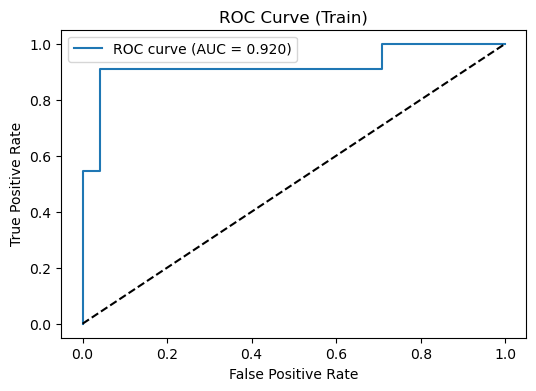


Train AUC: 0.920


In [16]:
# -------------------------------------------------------------------
# In-sample evaluation (training set) ROC, Precision, & Recall
# -------------------------------------------------------------------

# Predicted probabilities on training data
train_probs = logit_model.predict(sm.add_constant(ice_cream_train["Age"]))

train_pred_class = (train_probs >= 0.5).astype(int)

cm_train = confusion_matrix(ice_cream_train['buy_ind'], train_pred_class)
precision_train = precision_score(ice_cream_train['buy_ind'], train_pred_class)
recall_train = recall_score(ice_cream_train['buy_ind'], train_pred_class)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train:.3f}")
print(f"Recall (train):    {recall_train:.3f}")

# ROC & AUC
fpr, tpr, _ = roc_curve(ice_cream_train['buy_ind'], train_probs)
auc_train = roc_auc_score(ice_cream_train['buy_ind'], train_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_train:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Train)")
plt.legend()
plt.show()

print(f"\nTrain AUC: {auc_train:.3f}")



Test-set confusion matrix (threshold = 0.5):
          Pred 0  Pred 1
Actual 0      11       0
Actual 1       1       3

Test Precision: 1.000
Test Recall:    0.750
Test AUC:       0.955


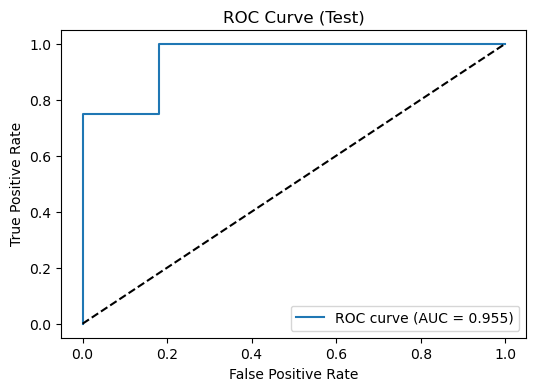

In [17]:
# -------------------------------------------------------------------
# Step 6: Test-set evaluation
# -------------------------------------------------------------------

# Predict on test set using the original logistic model (fitted on ice_cream_train)
test_probs = logit_model.predict(sm.add_constant(ice_cream_test["Age"]))
test_pred_class = (test_probs >= 0.5).astype(int)

cm_test = confusion_matrix(ice_cream_test['buy_ind'], test_pred_class)
precision_test = precision_score(ice_cream_test['buy_ind'], test_pred_class)
recall_test = recall_score(ice_cream_test['buy_ind'], test_pred_class)
auc_test = roc_auc_score(ice_cream_test['buy_ind'], test_probs)

print("\nTest-set confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_test,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))

print(f"\nTest Precision: {precision_test:.3f}")
print(f"Test Recall:    {recall_test:.3f}")
print(f"Test AUC:       {auc_test:.3f}")

fpr_test, tpr_test, _ = roc_curve(ice_cream_test['buy_ind'], test_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, label=f"ROC curve (AUC = {auc_test:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()
